In [1]:
import fitz  # PyMuPDF para leer el PDF
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import itertools
from nltk.util import ngrams
from collections import Counter

In [19]:
# Descargar recursos de NLTK (solo la primera vez)
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# 2. Leer el PDF (reemplaza por la ruta de tu archivo BobDylan.pdf)
ruta_pdf = "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_4/BobDylan.pdf"
doc = fitz.open(ruta_pdf)

In [21]:
texto = ""
for pagina in doc:
    texto += pagina.get_text()

# 3. Preprocesamiento básico
# - Pasar a minúsculas
# - Eliminar caracteres especiales
texto = texto.lower()
texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)

In [24]:
# 4. Tokenización
tokens = nltk.word_tokenize(texto, language="spanish")

# 5. Eliminar stopwords (palabras vacías)
stop_words = set(stopwords.words("spanish"))
tokens_filtrados = [t for t in tokens if t not in stop_words and len(t) > 2]

In [25]:
# ==========================
# ANÁLISIS DE N-GRAMAS
# ==========================

def generar_ngrama(tokens, n):
    return list(ngrams(tokens, n))

# 1-gramas (unigramas)
unigramas = generar_ngrama(tokens_filtrados, 1)
cont_unigramas = Counter(unigramas)

# 2-gramas (bigramas)
bigramas = generar_ngrama(tokens_filtrados, 2)
cont_bigramas = Counter(bigramas)

# 3-gramas (trigramas)
trigramas = generar_ngrama(tokens_filtrados, 3)
cont_trigramas = Counter(trigramas)


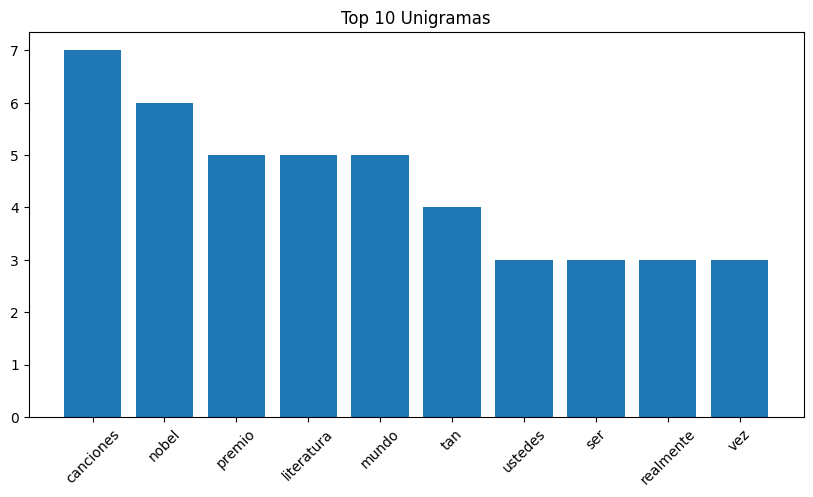

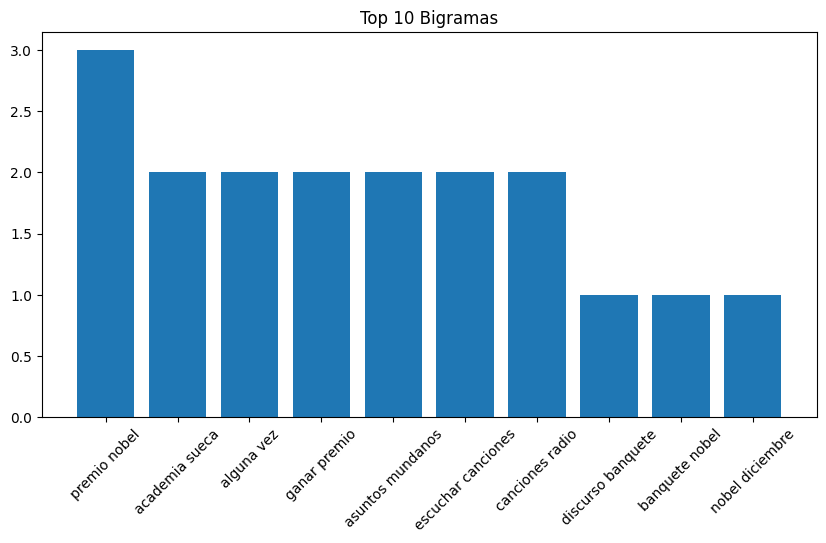

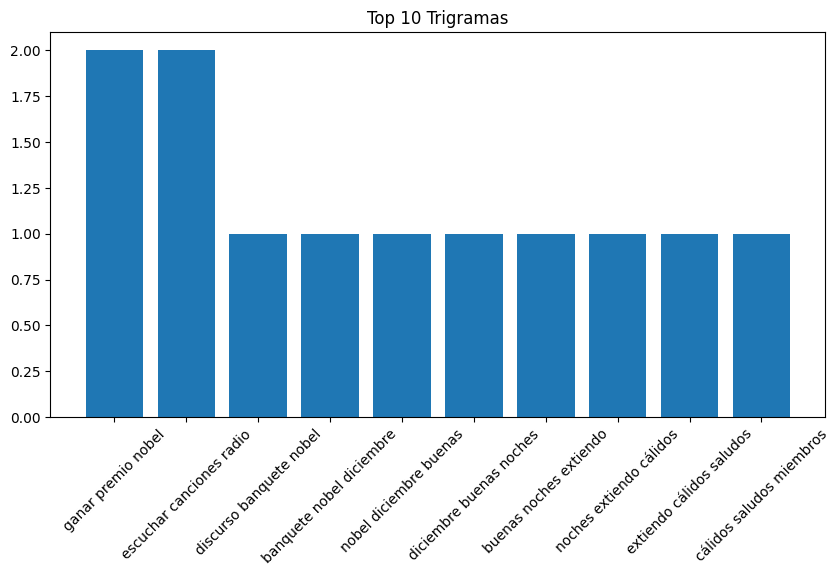

In [26]:
# ==========================
# VISUALIZACIÓN
# ==========================

def graficar_frecuencias(counter, titulo, n=10):
    etiquetas, valores = zip(*counter.most_common(n))
    etiquetas = [' '.join(e) for e in etiquetas]  # unir n-gramas
    plt.figure(figsize=(10,5))
    plt.bar(etiquetas, valores)
    plt.xticks(rotation=45)
    plt.title(titulo)
    plt.show()

# Graficar los top 10 de cada n-grama
graficar_frecuencias(cont_unigramas, "Top 10 Unigramas")
graficar_frecuencias(cont_bigramas, "Top 10 Bigramas")
graficar_frecuencias(cont_trigramas, "Top 10 Trigramas")

In [33]:
# ================================
# --- Conteo de N-gramas en tabla ---
# ================================
import pandas as pd

def mostrar_top(counter, titulo, n=10):
    df = pd.DataFrame(counter.most_common(n), columns=["N-grama", "Frecuencia"])
    df["N-grama"] = df["N-grama"].apply(lambda x: " ".join(x))  # unir palabras
    print(f"\n🔹 {titulo}")
    print(df.to_string(index=False))
    return df

# Unigramas
df_uni = mostrar_top(cont_unigramas, "Top 10 Unigramas")

# Bigramas
df_bi = mostrar_top(cont_bigramas, "Top 10 Bigramas")

# Trigramas
df_tri = mostrar_top(cont_trigramas, "Top 10 Trigramas")



🔹 Top 10 Unigramas
N-grama  Frecuencia
     de          35
    que          33
     en          31
      y          18
     la          16
     el          16
      a          14
   para          12
    mis           9
    más           9

🔹 Top 10 Bigramas
      N-grama  Frecuencia
        en la           6
        de la           4
        en el           4
 premio nobel           3
     el mundo           3
       de que           3
mis canciones           3
       lo que           3
     nobel de           2
      a todos           2

🔹 Top 10 Trigramas
             N-grama  Frecuencia
   la academia sueca           2
      con ustedes en           2
     el premio nobel           2
       todo el mundo           2
       de que estaba           2
     quiénes son los           2
para estas canciones           2
     canciones en la           2
         en la radio           2
     haciendo lo que           2


In [34]:
# ================================
# --- 5) Modelo simple de bigramas con suavizado Laplace ---
# ================================

import math

# 1. Construcción de bigramas y conteos
bigramas = generar_ngrama(tokens, 2)
cont_bigramas = Counter(bigramas)
cont_unigramas = Counter(tokens)

# 2. Función de probabilidad con suavizado de Laplace
def prob_bigram_laplace(palabra1, palabra2, cont_bigramas, cont_unigramas, vocabulario):
    bigrama = (palabra1, palabra2)
    num = cont_bigramas[bigrama] + 1   # +1 suavizado Laplace
    den = cont_unigramas[palabra1] + len(vocabulario)  # tamaño del vocabulario
    return num / den

# 3. Función de autocompletado
def predecir_siguiente(palabra, cont_bigramas, cont_unigramas, vocabulario, top=5):
    candidatos = []
    for w in vocabulario:
        p = prob_bigram_laplace(palabra, w, cont_bigramas, cont_unigramas, vocabulario)
        candidatos.append((w, p))
    # ordenar por probabilidad descendente
    candidatos = sorted(candidatos, key=lambda x: x[1], reverse=True)
    return candidatos[:top]

# --- Ejemplo de uso ---
vocabulario = set(tokens)

entrada = "vectorización"
predicciones = predecir_siguiente(entrada, cont_bigramas, cont_unigramas, vocabulario, top=5)

print(f"\n🔹 Palabra de entrada: {entrada}")
print("Posibles continuaciones (con Laplace):")
for palabra, prob in predicciones:
    print(f"{entrada} {palabra} -> {prob:.4f}")



🔹 Palabra de entrada: vectorización
Posibles continuaciones (con Laplace):
vectorización tomarse -> 0.0025
vectorización montarse -> 0.0025
vectorización adecuadamente -> 0.0025
vectorización tan -> 0.0025
vectorización años -> 0.0025


In [35]:
# ================================
# --- 6) Extracción de frases comunes (Collocations) ---
# ================================
import nltk
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures

# 1. Bigramas frecuentes
bigram_finder = BigramCollocationFinder.from_words(tokens)
bigram_finder.apply_freq_filter(3)  # solo bigramas que aparecen >= 3 veces
top_bigrams = bigram_finder.nbest(BigramAssocMeasures.likelihood_ratio, 10)

print("\n🔹 Top 10 Bigramas más comunes (Collocations):")
for b in top_bigrams:
    print(" ".join(b))

# 2. Trigramas frecuentes
trigram_finder = TrigramCollocationFinder.from_words(tokens)
trigram_finder.apply_freq_filter(2)  # solo trigramas que aparecen >= 2 veces
top_trigrams = trigram_finder.nbest(TrigramAssocMeasures.likelihood_ratio, 10)

print("\n🔹 Top 10 Trigramas más comunes (Collocations):")
for t in top_trigrams:
    print(" ".join(t))



🔹 Top 10 Bigramas más comunes (Collocations):
premio nobel
en la
mis canciones
el mundo
en el
de la
lo que
de que

🔹 Top 10 Trigramas más comunes (Collocations):
el premio nobel
la academia sueca
quiénes son los
en la radio
todo el mundo
son mis canciones
para estas canciones
haciendo lo que
canciones en la
con ustedes en


c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


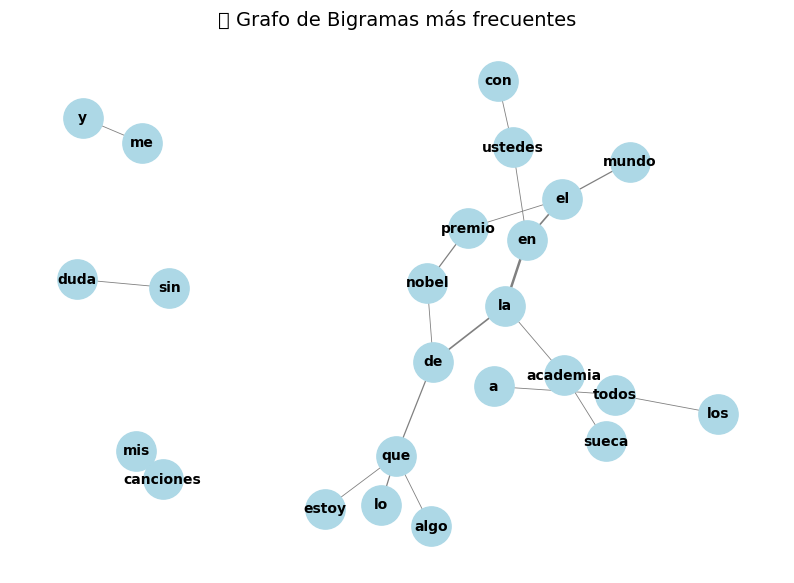

In [36]:
# ================================
# --- 10) Grafo de bigramas ---
# ================================
import networkx as nx
import matplotlib.pyplot as plt

# 1. Generar bigramas y contar frecuencias
bigramas = generar_ngrama(tokens, 2)
cont_bigramas = Counter(bigramas)

# 2. Seleccionar los bigramas más frecuentes (ej: top 20)
top_bigramas = cont_bigramas.most_common(20)

# 3. Crear grafo
G = nx.Graph()

# Añadir nodos y aristas con peso
for (w1, w2), freq in top_bigramas:
    G.add_edge(w1, w2, weight=freq)

# 4. Dibujar el grafo
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, k=0.5, seed=42)  # disposición del grafo
edges = G.edges(data=True)

# Grosor de las aristas proporcional a la frecuencia
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[d['weight']*0.3 for (u,v,d) in edges], edge_color="gray")

plt.title("🔹 Grafo de Bigramas más frecuentes", fontsize=14)
plt.axis("off")
plt.show()


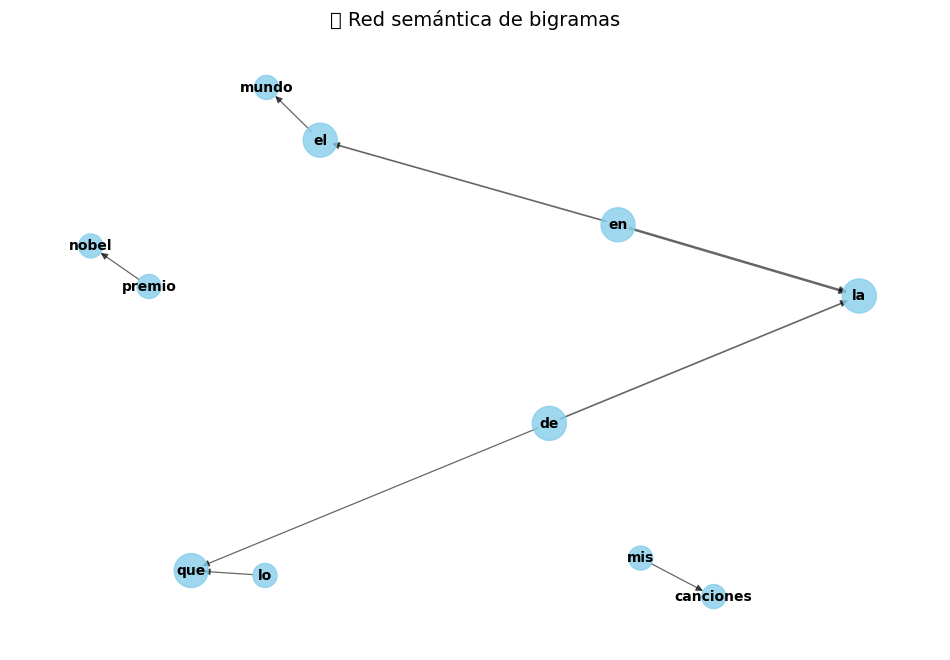

In [37]:
# ================================
# --- Red semántica de n-gramas ---
# ================================
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# 1. Generar bigramas y contar frecuencias
bigramas = generar_ngrama(tokens, 2)
cont_bigramas = Counter(bigramas)

# 2. Filtro: quedarnos con bigramas que aparecen al menos 3 veces
bigramas_frecuentes = {bg: freq for bg, freq in cont_bigramas.items() if freq >= 3}

# 3. Crear grafo dirigido (opcional: puede ser no dirigido)
G = nx.DiGraph()

for (w1, w2), freq in bigramas_frecuentes.items():
    G.add_edge(w1, w2, weight=freq)

# 4. Visualización
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Tamaño de nodos según grado
node_sizes = [G.degree(n)*300 for n in G.nodes()]

# Dibujar nodos y aristas
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, width=[d['weight']*0.3 for (u,v,d) in G.edges(data=True)], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title("🔹 Red semántica de bigramas", fontsize=14)
plt.axis("off")
plt.show()


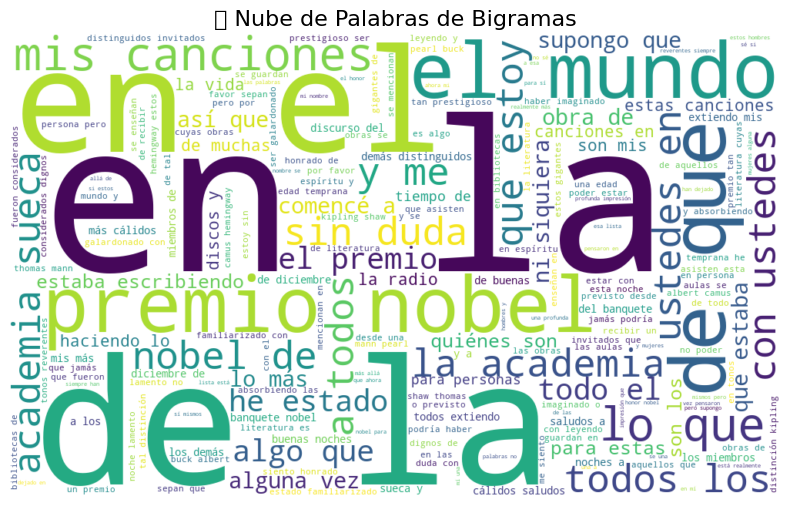

In [38]:
# ================================
# --- Nube de palabras de n-gramas ---
# ================================
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Preparar frecuencias de bigramas (puedes cambiar a unigramas o trigramas)
bigramas = generar_ngrama(tokens, 2)
cont_bigramas = Counter(bigramas)

# Convertir a diccionario con formato "palabra1 palabra2" : frecuencia
bigram_dict = {" ".join(k): v for k, v in cont_bigramas.items()}

# 2. Crear nube de palabras
wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      colormap="viridis").generate_from_frequencies(bigram_dict)

# 3. Mostrar
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("🔹 Nube de Palabras de Bigramas", fontsize=16)
plt.show()


In [39]:
# ================================
# --- Cálculo de TF, DF, IDF y TF-IDF ---
# ================================
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1. Suponemos que 'texto' contiene TODO el PDF como un único documento
#    -> Si tienes varios documentos, colócalos en una lista: corpus = [doc1, doc2, doc3...]
corpus = [texto]

# --- TF (Term Frequency) y DF (Document Frequency) ---
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# DataFrame con conteos absolutos (TF en cada documento)
tf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Document Frequency (DF): en cuántos documentos aparece cada término
df_series = (X > 0).sum(axis=0).A1
df = pd.DataFrame({"Término": vectorizer.get_feature_names_out(), "DF": df_series})

# --- IDF (Inverse Document Frequency) y TF-IDF ---
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# DataFrame con valores TF-IDF
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# ================================
# Mostrar resultados
# ================================
print("\n🔹 Term Frequency (TF) - Conteos absolutos (primeras 10 columnas):")
print(tf_df.iloc[:, :10])

print("\n🔹 Document Frequency (DF) - Top 10 términos:")
print(df.sort_values(by="DF", ascending=False).head(10))

print("\n🔹 TF-IDF - Primeras 10 columnas:")
print(tfidf_df.iloc[:, :10])



🔹 Term Frequency (TF) - Conteos absolutos (primeras 10 columnas):
   absorbiendo  academia  actores  adecuada  adecuadamente  adecuados  \
0            1         2        1         1              1          1   

   adolescente  agradecido  agradezco  ahora  
0            1           1          1      1  

🔹 Document Frequency (DF) - Top 10 términos:
           Término  DF
399         última   1
0      absorbiendo   1
1         academia   1
2          actores   1
3         adecuada   1
4    adecuadamente   1
5        adecuados   1
6      adolescente   1
7       agradecido   1
8        agradezco   1

🔹 TF-IDF - Primeras 10 columnas:
   absorbiendo  academia   actores  adecuada  adecuadamente  adecuados  \
0     0.013228  0.026456  0.013228  0.013228       0.013228   0.013228   

   adolescente  agradecido  agradezco     ahora  
0     0.013228    0.013228   0.013228  0.013228  


In [40]:
# ================================
# Corpus como un único documento
# ================================

# 'texto' contiene todo el PDF leído (ya lo cargamos antes con fitz)
corpus = [texto]   # lista con un único documento

print("Número de documentos en corpus:", len(corpus))
print("Vista previa del documento (primeros 500 caracteres):\n")
print(corpus[0][:500])


Número de documentos en corpus: 1
Vista previa del documento (primeros 500 caracteres):

discurso del banquete nobel  de diciembre de  
buenas noches a todos extiendo mis más cálidos saludos a los miembros de la academia 
sueca y a todos los demás distinguidos invitados que asisten esta noche 
lamento no poder estar con ustedes en persona pero por favor sepan que estoy sin duda con 
ustedes en espíritu y me siento honrado de recibir un premio tan prestigioso ser galardonado 
con el premio nobel de literatura es algo que jamás podría haber imaginado o previsto 
desde una edad tempran


In [41]:
# ================================
# --- Bag of Words (BoW) ---
# ================================
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Usamos el corpus como un único documento (texto completo del PDF)
corpus = [texto]

# 1. Crear el modelo BoW
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# 2. Convertir a DataFrame
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 3. Mostrar resultados
print("🔹 Bag of Words (BoW) - Primeras 20 palabras:\n")
print(bow_df.iloc[:, :20])  # primeras 20 columnas
print("\nDimensiones del BoW:", bow_df.shape)


🔹 Bag of Words (BoW) - Primeras 20 palabras:

   absorbiendo  academia  actores  adecuada  adecuadamente  adecuados  \
0            1         2        1         1              1          1   

   adolescente  agradecido  agradezco  ahora  albergar  albert  alcanzar  \
0            1           1          1      1         1       1         1   

   alejado  algo  alguien  alguna  algunas  allá  allí  
0        1     2        1       2        1     1     1  

Dimensiones del BoW: (1, 400)


In [42]:
# ================================
# --- Guardar texto depurado en TXT ---
# ================================
# Suponemos que la variable 'texto' contiene el texto ya depurado
# (si trabajaste con 'tokens', puedes unirlos de nuevo en un string)

# 1. Si quieres guardar el texto depurado como un string continuo:
with open("texto_depurado.txt", "w", encoding="utf-8") as f:
    f.write(texto)

print("✅ Texto depurado guardado en 'texto_depurado.txt'")

# 2. Si prefieres guardar los tokens (una palabra por línea):
with open("tokens_depurados.txt", "w", encoding="utf-8") as f:
    for token in tokens:
        f.write(token + "\n")

print("✅ Tokens depurados guardados en 'tokens_depurados.txt'")


✅ Texto depurado guardado en 'texto_depurado.txt'
✅ Tokens depurados guardados en 'tokens_depurados.txt'


✅ Número de páginas con texto: 2


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\ACER\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


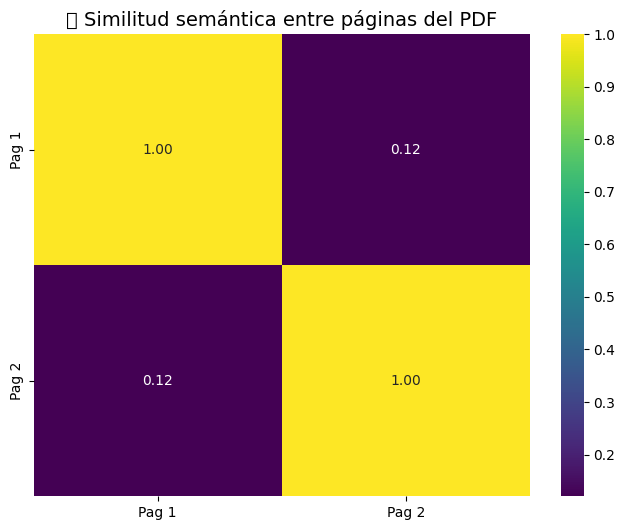

In [6]:
# ================================
# --- Heatmap de similitud semántica entre páginas (versión corregida) ---
# ================================
import fitz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords

# Descargar stopwords en español (solo la primera vez)
nltk.download("stopwords")
stop_words_es = stopwords.words("spanish")

# 1. Leer PDF y extraer texto por páginas
ruta_pdf = "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_4/BobDylan.pdf"
doc = fitz.open(ruta_pdf)

corpus_paginas = []
for pagina in doc:
    texto = pagina.get_text().strip()
    if texto:  # solo añadimos si no está vacío
        corpus_paginas.append(texto)

print(f"✅ Número de páginas con texto: {len(corpus_paginas)}")

# 2. Vectorización con TF-IDF usando stopwords en español
vectorizer = TfidfVectorizer(stop_words=stop_words_es, lowercase=True)
X = vectorizer.fit_transform(corpus_paginas)

# 3. Calcular matriz de similitud coseno
sim_matrix = cosine_similarity(X)

# 4. Graficar heatmap
plt.figure(figsize=(8,6))
sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=[f"Pag {i+1}" for i in range(len(corpus_paginas))],
            yticklabels=[f"Pag {i+1}" for i in range(len(corpus_paginas))])

plt.title("🔹 Similitud semántica entre páginas del PDF", fontsize=14)
plt.show()
